# Instructions
1. Rename this file with your name and date of submission E.g., john_doe_yyyymmdd.ipynb
2. The csv files include ohlc and volume data from 2024-03-18 to 2024-06-14. For the week of **May 27th** (2024-05-27 to 2024-05-31), identify important prices or ranges for that week. Define "important" and provide an explanation. You can use data outside of this range to test hypotheses.
3. Analyze the data and create a module to identify this important price.
    - (Optional) Create a ranking system to score probability or price importance.
4. Feel free to use any resources available.
4. Provide a write up below or in a separate document to explain your thought process, hypotheses, and any other interesting points you observed through your analysis.

Keep in mind anomalous times including 08:30 EST due to high impact news. 10:00 AM etc. Use this [calendar](https://www.investing.com/economic-calendar/).

**Evaluation Metrics**<br>
We will assess your submission based on the following three categories:
1. Novelty of idea/approach
2. Analytical ability and scientific reasoning
3. Coding skill

## Table Schema

* **ts_event**: time in EST
* **open**: price at start of time interval
* **high**: max price during time interval
* **low**: min price during time interval
* **close**: last price of time interval
* **volume**: total volume traded (A + B + N)
* **volume_A**: total volume traded on A side
* **volume_B**: total volume traded on B side
* **volume_N**: total volume traded on N side


In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import yfinance as yf
import torch
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import scipy
import pandas_ta as ta

import warnings
warnings.filterwarnings("ignore")

In [58]:
df_1D = pd.read_csv('1D.csv')
df_60min = pd.read_csv('60min.csv')
df_5min = pd.read_csv('5min.csv')
df_1min = pd.read_csv('1min.csv')
df_10s = pd.read_csv('10s.csv')

In [59]:
df_1D

,ts_event,open,high,low,close,volume,volume_A,volume_B,volume_N
0,2024-03-18 00:00:00-04:00,5193.75,5240.25,5192.00,5207.75,1313236,655955,657214,67
1,2024-03-19 00:00:00-04:00,5208.00,5244.75,5186.00,5236.50,1299315,641874,657426,15
2,2024-03-20 00:00:00-04:00,5236.50,5307.00,5233.00,5306.75,1340903,667878,672977,48
3,2024-03-21 00:00:00-04:00,5306.50,5322.75,5299.00,5303.00,1241147,617661,623477,9
4,2024-03-22 00:00:00-04:00,5303.00,5311.75,5287.75,5289.75,1009854,511195,498659,0
...,...,...,...,...,...,...,...,...,...
74,2024-06-13 00:00:00-04:00,5440.75,5452.75,5408.50,5441.25,1321074,663234,657830,10
75,2024-06-14 00:00:00-04:00,5441.25,5443.00,5397.75,5435.75,1068390,532796,535400,194
76,2024-06-16 00:00:00-04:00,5435.50,5439.75,5432.00,5435.75,11363,5697,5623,43
77,2024-06-17 00:00:00-04:00,5435.75,5494.00,5424.75,5478.50,443482,217506,225960,16


What are strategies can be is:
1) We will perform market profiling on each time frame
2) We will try to find some confluent factors in every time frame profile
3) then rank these prices according to the frequency of the confluence
4) the resultant prices will be the important prices
5) As we have to analyze one particular week, we need to look behind some period before the advent of the week to determine the important prices at the start of the week

In [60]:
df_60min

,ts_event,open,high,low,close,volume,volume_A,volume_B,volume_N
0,2024-03-18 00:00:00-04:00,5193.75,5196.50,5193.25,5195.50,3527,1808,1719,0
1,2024-03-18 01:00:00-04:00,5195.75,5198.25,5195.25,5197.50,4096,2140,1956,0
2,2024-03-18 02:00:00-04:00,5197.75,5199.25,5197.00,5197.25,4170,2183,1987,0
3,2024-03-18 03:00:00-04:00,5197.25,5198.75,5193.75,5194.25,7919,4079,3840,0
4,2024-03-18 04:00:00-04:00,5194.25,5202.25,5192.00,5202.00,16710,7818,8892,0
...,...,...,...,...,...,...,...,...,...
1509,2024-06-18 19:00:00-04:00,5497.00,5497.25,5494.25,5495.50,633,328,305,0
1510,2024-06-18 20:00:00-04:00,5495.50,5495.75,5491.25,5492.25,896,526,370,0
1511,2024-06-18 21:00:00-04:00,5492.00,5493.50,5491.50,5492.00,675,309,366,0
1512,2024-06-18 22:00:00-04:00,5492.25,5494.25,5492.00,5493.00,354,146,208,0


In [61]:
df_60min['ts_event'] = pd.to_datetime(df_60min['ts_event'])
start_time = '2024-05-27 09:30:00'
end_time = '2024-05-31 16:00:00'
df_filtered = df_60min[(df_60min['ts_event'] >= start_time) & (df_60min['ts_event'] <= end_time)]

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=df_filtered['ts_event'], y=df_filtered['close'], name="Close Price", line=dict(color="red", width=2)),
    secondary_y=False,
)
fig.add_trace(
    go.Bar(x=df_filtered['ts_event'], y=df_filtered['volume'], name="Volume", marker_color="gray", opacity=0.3),
    secondary_y=True,
)

fig.update_xaxes(title_text="Time", tickformat="%Y-%m-%d %H:%M")

fig.update_yaxes(title_text="Price", secondary_y=False, color="red", tickformat=".2f")
fig.update_yaxes(title_text="Volume", secondary_y=True, color="gray")

fig.update_layout(
    title="Price and Volume for May 27 to May 31, 2024",
    xaxis_tickangle=-45,
    height=800,  
    template="plotly_white",
)

fig.show()

News flow during 27 May to 31 May 2024

Despite the low-impact economic news for the week of May 27, 2024, markets continued to slide downward, reflecting broader concerns beyond the immediate data releases. Even with most indicators and central bank speeches aligning with expectations, investor sentiment remained weak. 

Key economic indicators, like Germany’s Ifo Business Climate, U.S. consumer confidence, and the U.S. GDP growth revision, largely painted a picture of modest growth and controlled inflation without major surprises. However, the steady declines in both consumer and business sentiment, coupled with persistently cautious Fed rhetoric, seemed to weigh on the markets. The underwhelming PMI figures from China, signaling slower manufacturing activity, further fueled fears of a global economic slowdown.

Without any positive economic catalysts, traders seemed to lean toward a risk-off sentiment, resulting in a steady decline across various asset classes. This ongoing sell-off highlighted the market’s sensitivity to any hint of global slowdown, amplified by concerns about sticky inflation, high interest rates, and geopolitical uncertainties. The continuous downward trend suggested that, even with no major disruptions, underlying worries about future growth prospects and tighter financial conditions dominated investor sentiment, pushing markets lower through the week.

Market Profile - For Most Visited Levels by Price

In [62]:
def find_levels( price: np.array, atr: float, first_w: float = 0.1, atr_mult: float = 3.0, prom_thresh: float = 0.1):

    last_w = 1.0
    w_step = (last_w - first_w) / len(price)
    weights = first_w + np.arange(len(price)) * w_step
    weights[weights < 0] = 0.0

    kernal = scipy.stats.gaussian_kde(price, bw_method=atr*atr_mult, weights=weights)

    min_v = np.min(price)
    max_v = np.max(price)
    step = (max_v - min_v) / 200
    price_range = np.arange(min_v, max_v, step)
    pdf = kernal(price_range) 

    pdf_max = np.max(pdf)
    prom_min = pdf_max * prom_thresh

    peaks, props = scipy.signal.find_peaks(pdf, prominence=prom_min)
    levels = [] 
    for peak in peaks:
        levels.append(np.exp(price_range[peak]))

    return levels, peaks, props, price_range, pdf, weights

In [63]:
def support_resistance_levels(
        data: pd.DataFrame, lookback: int, 
        first_w: float = 0.01, atr_mult:float=3.0, prom_thresh:float =0.25
):

    # Get log average true range, 
    atr = ta.atr(np.log(data['high']), np.log(data['low']), np.log(data['close']), lookback)

    all_levels = [None] * len(data)
    for i in range(lookback, len(data)):
        i_start  = i - lookback
        vals = np.log(data.iloc[i_start+1: i+1]['close'].to_numpy())
        levels, peaks, props, price_range, pdf, weights= find_levels(vals, atr.iloc[i], first_w, atr_mult, prom_thresh)
        all_levels[i] = levels
        
    return all_levels, pdf

MovieWriter imagemagick unavailable; using Pillow instead.


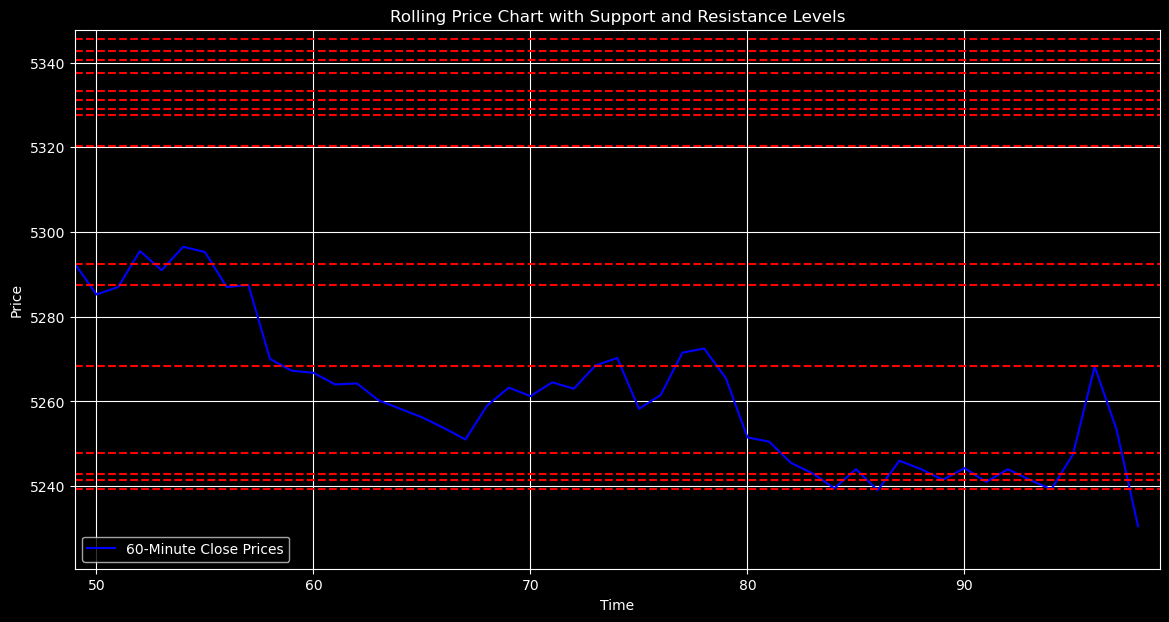

In [64]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

# Assuming df_60min is your DataFrame and levels is a list/array of support/resistance levels
levels, pdf = support_resistance_levels(df_60min, 365, first_w=1.0, atr_mult=3.0)

# Extract the specific price range for plotting
prices = df_60min['close'][1127:1226].values

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(14, 7))
ax.set_title('Rolling Price Chart with Support and Resistance Levels')
ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.grid()

# Number of points to display at a time
rolling_window_size = 50  # Change this value to adjust how many points to display
price_line, = ax.plot([], [], label='60-Minute Close Prices', color='blue')
ax.set_xlim(0, rolling_window_size)  # Initial x-axis limits
ax.set_ylim(min(prices) - 10, max(prices) + 10)

# Adding the legend
ax.legend()

# Function to initialize the plot
def init():
    price_line.set_data([], [])
    return price_line,

# Function to update the plot for each frame
def update(frame):
    # Calculate the start and end indices for the rolling window
    start_idx = max(0, frame - rolling_window_size + 1)
    end_idx = frame + 1

    # Update the price line data for the current frame
    x_data = np.arange(start_idx, end_idx)
    y_data = prices[start_idx:end_idx]
    price_line.set_data(x_data, y_data)

    # Overlay support/resistance levels
    # Clear previous lines before redrawing
    for line in ax.lines[1:]:  # Skip the first line (the price line)
        line.remove()

    for level in levels[1127 + frame]:  # Adjust index based on frame
        ax.axhline(y=level, color='red', linestyle='--')

    # Update x-axis limits to create the rolling effect
    ax.set_xlim(start_idx, end_idx)  # Shift x limits based on current frame

    return price_line,

# Create the animation
ani = FuncAnimation(fig, update, frames=len(prices), init_func=init, blit=True, repeat=False)
ani.save('rolling_animation.gif', writer='imagemagick', fps=4)  # Save the animation as GIF
plt.show()


Price Distribution

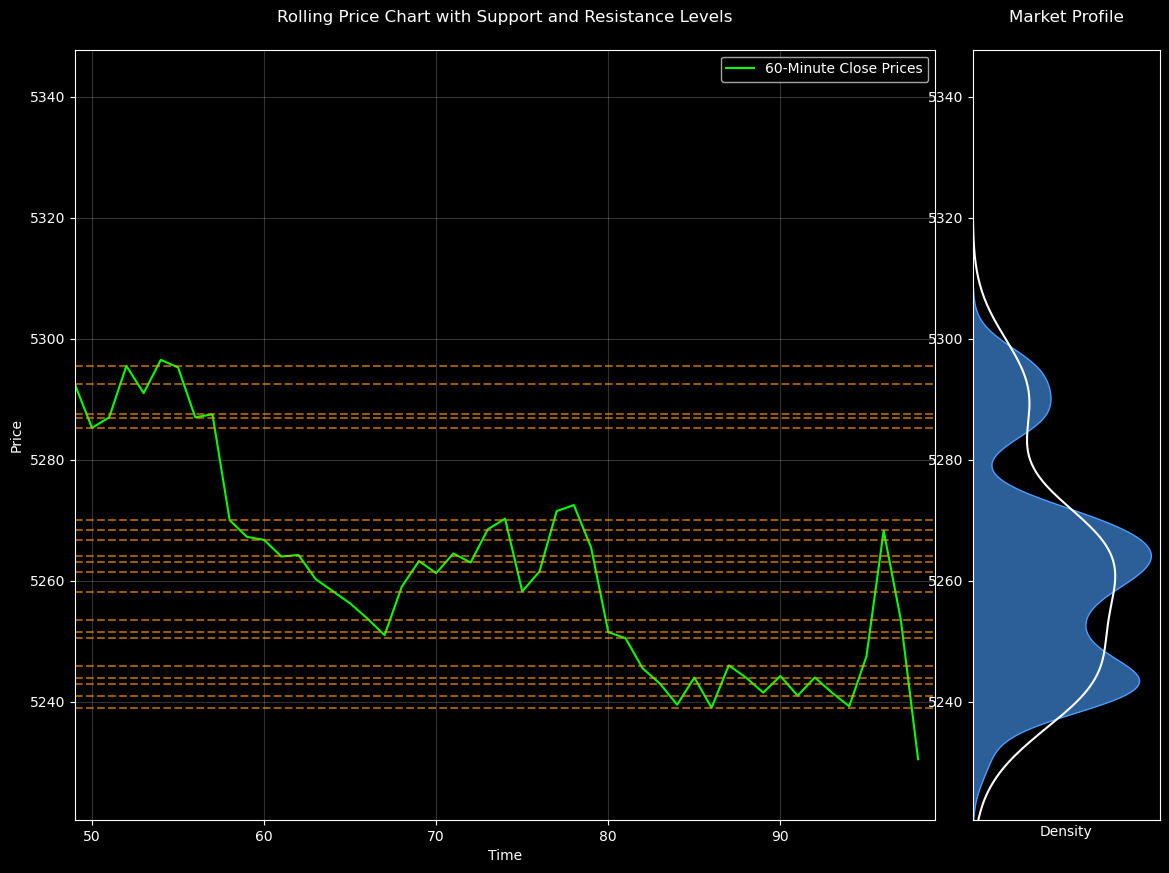

In [65]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import seaborn as sns

# Assuming df_60min is your DataFrame and levels is a list/array of support/resistance levels
levels, pdf = support_resistance_levels(df_60min, 50, first_w=1.0, atr_mult=3.0)

# Extract the specific price range for plotting
prices = df_60min['close'][1127:1226].values

# Set the style for better visibility
plt.style.use('dark_background')

# Create a figure and axis for the plot with subplots
fig = plt.figure(figsize=(14, 10))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=4)  # Main price chart
ax2 = plt.subplot2grid((1, 5), (0, 4), colspan=1, sharey=ax1)  # Market profile chart

# Configure the first subplot for the rolling price chart
ax1.set_title('Rolling Price Chart with Support and Resistance Levels', pad=20)
ax1.set_xlabel('Time')
ax1.set_ylabel('Price')
ax1.grid(alpha=0.2)

# Number of points to display at a time
rolling_window_size = 50
price_line, = ax1.plot([], [], label='60-Minute Close Prices', color='#00ff00', linewidth=1.5)
ax1.set_xlim(0, rolling_window_size)
ax1.set_ylim(min(prices) - 10, max(prices) + 10)

# Adding the legend to the first subplot
ax1.legend()

def init():
    price_line.set_data([], [])
    return price_line,

def update(frame):
    # Calculate the start and end indices for the rolling window
    start_idx = max(0, frame - rolling_window_size + 1)
    end_idx = frame + 1
    
    # Update the price line data
    x_data = np.arange(start_idx, end_idx)
    y_data = prices[start_idx:end_idx]
    price_line.set_data(x_data, y_data)
    
    # Clear previous support/resistance lines
    for line in ax1.lines[1:]:
        line.remove()
    
    # Update support/resistance levels
    if 1127 + frame < len(levels):
        for level in levels[1127 + frame]:
            ax1.axhline(y=level, color='#ff9900', linestyle='--', alpha=0.6)
    
    # Update x-axis limits
    ax1.set_xlim(start_idx, end_idx)
    
    # Update market profile
    ax2.clear()
    # Use a more visible color scheme for the density plot
    sns.kdeplot(
        data=prices[start_idx:end_idx],
        bw_adjust=0.5,
        fill=True,
        vertical=True,
        color='#4a9eff',
        alpha=0.6,
        ax=ax2
    )
    ax2.set_title('Market Profile', pad=20)
    ax2.grid(False)
    ax2.set_xticks([])
    
    # Add volume concentration levels
    kde = sns.kdeplot(
        data=prices[start_idx:end_idx],
        vertical=True,
        color='#ffffff',
        ax=ax2
    )
    
    return price_line,

# Create the animation with adjusted FPS
ani = FuncAnimation(
    fig,
    update,
    frames=len(prices),
    init_func=init,
    blit=True,
    repeat=False,
    interval=250  # 4 FPS (1000ms / 4)
)

# Save the animation
ani.save('rolling_market_profile.gif', writer='pillow', fps=4)
plt.show()

Rolling Market Profile Volume

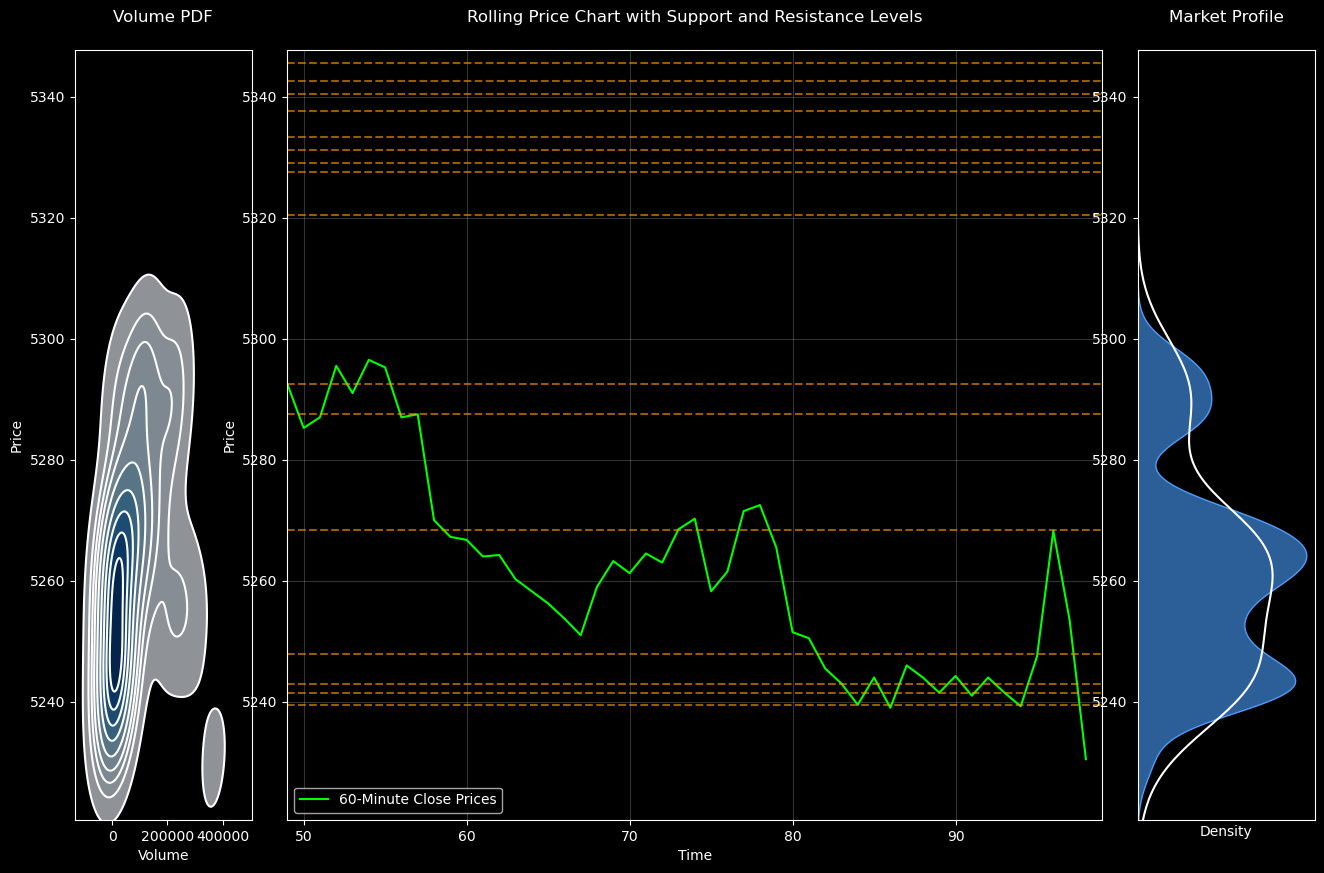

In [66]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import seaborn as sns

levels, pdf = support_resistance_levels(df_60min, 365, first_w=1.0, atr_mult=3.0)

prices = df_60min['close'][1127:1226].values
volume = df_60min['volume'][1127:1226].values
plt.style.use('dark_background')

fig = plt.figure(figsize=(16, 10))
ax_volume = plt.subplot2grid((1, 6), (0, 0), colspan=1)  # Volume PDF
ax1 = plt.subplot2grid((1, 6), (0, 1), colspan=4)  # Price chart
ax2 = plt.subplot2grid((1, 6), (0, 5), colspan=1, sharey=ax1)  # Market Profile

# Set consistent y-axis limits for all subplots
y_min = min(prices) - 10
y_max = max(prices) + 10

ax1.set_title('Rolling Price Chart with Support and Resistance Levels', pad=20)
ax1.set_xlabel('Time')
ax1.set_ylabel('Price')
ax1.grid(alpha=0.2)

rolling_window_size = 50
price_line, = ax1.plot([], [], label='60-Minute Close Prices', color='#00ff00', linewidth=1.5)
ax1.set_xlim(0, rolling_window_size)
ax1.set_ylim(y_min, y_max)
ax1.legend()

# Set y-axis limits for volume and market profile subplots
ax_volume.set_ylim(y_min, y_max)
ax2.set_ylim(y_min, y_max)

def init():
    price_line.set_data([], [])
    return price_line,

def update(frame):
    start_idx = max(0, frame - rolling_window_size + 1)
    end_idx = frame + 1
    
    x_data = np.arange(start_idx, end_idx)
    y_data = prices[start_idx:end_idx]
    price_line.set_data(x_data, y_data)
    
    # Clear previous lines in price chart
    for line in ax1.lines[1:]:
        line.remove()

    # Plot support and resistance levels
    if 1127 + frame < len(levels):
        for level in levels[1127 + frame]:
            ax1.axhline(y=level, color='#ff9900', linestyle='--', alpha=0.6)
    ax1.set_xlim(start_idx, end_idx)
  
    # Clear and update volume PDF
    ax_volume.clear()
    volume_subset = volume[start_idx:end_idx]
    price_subset = prices[start_idx:end_idx]
    
    # Create a DataFrame-like structure for seaborn
    sns.kdeplot(
        x=volume_subset,
        y=price_subset,
        fill=True,
        cmap='Blues',
        alpha=0.6,
        ax=ax_volume
    )
    
    # Add contour lines
    sns.kdeplot(
        x=volume_subset,
        y=price_subset,
        color='white',
        ax=ax_volume
    )
    
    ax_volume.set_title('Volume PDF', pad=20)
    ax_volume.set_xlabel('Volume')
    ax_volume.set_ylabel('Price')
    ax_volume.set_ylim(y_min, y_max)  # Maintain consistent y-axis
  
    # Clear and update market profile
    ax2.clear()
    sns.kdeplot(
        data=prices[start_idx:end_idx],
        bw_adjust=0.5,
        fill=True,
        vertical=True,
        color='#4a9eff',
        alpha=0.6,
        ax=ax2
    )
    ax2.set_title('Market Profile', pad=20)
    ax2.grid(False)
    ax2.set_xticks([])
    ax2.set_ylim(y_min, y_max)  # Maintain consistent y-axis

    # Add white line for market profile
    kde = sns.kdeplot(
        data=prices[start_idx:end_idx],
        vertical=True,
        color='#ffffff',
        ax=ax2
    )
    
    return price_line,

ani = FuncAnimation(
    fig,
    update,
    frames=len(prices),
    init_func=init,
    blit=True,
    repeat=False,
    interval=250  
)

ani.save('rolling_market_profile_volume.gif', writer='pillow', fps=4)
plt.show()

Hello